In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Data

In [2]:
sample_data_path = 'data/sample.csv'

- the input data contains relative abundance and the phenotype (CRC) label
- The subject id column is set as the index of the dataframe

In [3]:
df = pd.read_csv(sample_data_path,index_col=0)
df.head(3)

,Parabacteroides_unclassified,Atopobium_parvulum,Ruminococcus_obeum,Acidaminococcus_unclassified,Ruminococcus_gnavus,Megasphaera_unclassified,Eubacterium_rectale,Bacteroides_vulgatus,Clostridium_hathewayi,Odoribacter_laneus,...,Clostridium_ramosum,Gordonibacter_pamelaeae,Parvimonas_micra,Roseburia_unclassified,Anaerostipes_caccae,Escherichia_coli,Brachyspira_unclassified,Butyricicoccus_pullicaecorum,Bacteroides_intestinalis,CRC
subject_id,,,,,,,,,,,,,,,,,,,,,
10037,0.00000,0.00000,0.00597,0.0,2.47269,1.14481,6.58736,17.69016,0.16283,0.0,...,0.09658,0.01650,0.00000,0.00000,0.0,1.12283,0.0,0.0,0.0,0
10048,0.00000,0.00585,1.84816,0.0,0.49364,0.00000,0.53973,2.94942,0.00000,0.0,...,0.00000,0.02426,0.00000,0.08926,0.0,0.01656,0.0,0.0,0.0,0
10080,0.00433,0.00646,0.00000,0.0,7.63930,0.00000,0.00000,0.00000,0.00000,0.0,...,0.54644,0.00000,0.00015,0.00000,0.0,3.43931,0.0,0.0,0.0,0


In [4]:
X = df.drop('CRC',axis=1)
y = df['CRC']

# 2. Abundance Filtering

SHAPMAT provides a module for abundance filtering. There are two parameters to set:
1. __abundance_threshold__: abundance under this threshold will be set to 0. (default: 1e-15)
2. __prevalence_theshold__: features with number of zeros more than this threshold will be removed. (default: 0.9)

In [5]:
from shapmat.abundance_filter import ab_filter

In [6]:
X_filtered = ab_filter(data=X,abundance_threshold=1e-5, prevalence_threshold=0.9)
X_filtered.head(3)

,Parabacteroides_unclassified,Atopobium_parvulum,Ruminococcus_obeum,Acidaminococcus_unclassified,Ruminococcus_gnavus,Megasphaera_unclassified,Eubacterium_rectale,Bacteroides_vulgatus,Clostridium_hathewayi,Odoribacter_laneus,...,Holdemania_unclassified,Clostridium_ramosum,Gordonibacter_pamelaeae,Parvimonas_micra,Roseburia_unclassified,Anaerostipes_caccae,Escherichia_coli,Brachyspira_unclassified,Butyricicoccus_pullicaecorum,Bacteroides_intestinalis
subject_id,,,,,,,,,,,,,,,,,,,,,
10037,0.00000,0.00000,0.00597,0.0,2.47269,1.14481,6.58736,17.69016,0.16283,0.0,...,0.0,0.09658,0.01650,0.00000,0.00000,0.0,1.12283,0.0,0.0,0.0
10048,0.00000,0.00585,1.84816,0.0,0.49364,0.00000,0.53973,2.94942,0.00000,0.0,...,0.0,0.00000,0.02426,0.00000,0.08926,0.0,0.01656,0.0,0.0,0.0
10080,0.00433,0.00646,0.00000,0.0,7.63930,0.00000,0.00000,0.00000,0.00000,0.0,...,0.0,0.54644,0.00000,0.00015,0.00000,0.0,3.43931,0.0,0.0,0.0


# 3. Evaluate an ML model using Cross-validation

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

In [8]:
model = RandomForestClassifier(random_state=0)
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=0) # 10-fold 10-repeated Cross-validation
cv_score_auc = cross_val_score(model, X_filtered, y, cv = rkf,scoring='roc_auc')

In [9]:
mean_auc = cv_score_auc.mean().round(2)
mean_auc

0.82

# 4. Generate SHAP values

In [10]:
from shapmat.explainer import Explainer

In [11]:
model = RandomForestClassifier(random_state=0).fit(X_filtered,y)

In [12]:
# Get predicted probability
y_pred_proba = model.predict_proba(X_filtered)[:, 1] # CRC proba
y_pred_proba = pd.DataFrame(y_pred_proba,index=X_filtered.index)

- Below we only obtain the SHAP values of the correctly predicted samples by setting correct_pred_only=True
- We also remove features that have mean(|SHAP|) of zero (features that have no effects to the predictions)

In [13]:
# Calculate SHAP values
RF_explainer = Explainer(X=X_filtered,y=y,model=model)
shap_values = RF_explainer.shap()
shap_values_df = RF_explainer.shap_df(filter_zero_column=True,correct_pred_only=True)

Number of features with nonzero mean(|SHAP|): 201/201


# 5. Local Explanation

In [14]:
from shapmat.shap_plot import waterfall_plot

Text(0.5, 1.0, 'Local explanation of Subject ID 12014')

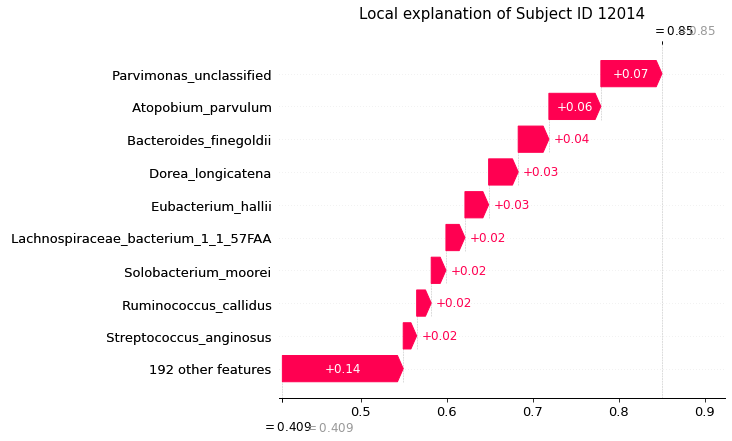

In [15]:
subject_id = 12014 # depending on the input dataframe, the subject_id can be a string as well.
explainer_object = RF_explainer.explainer()
waterfall_plot(explainer=explainer_object,shap_df=shap_values_df,max_display=10,subject_id=subject_id)
plt.title(f'Local explanation of Subject ID {subject_id}',fontsize=15)

# 6. Global Explanation (Summary Plot)

In [16]:
from shapmat.shap_plot import summary_plot

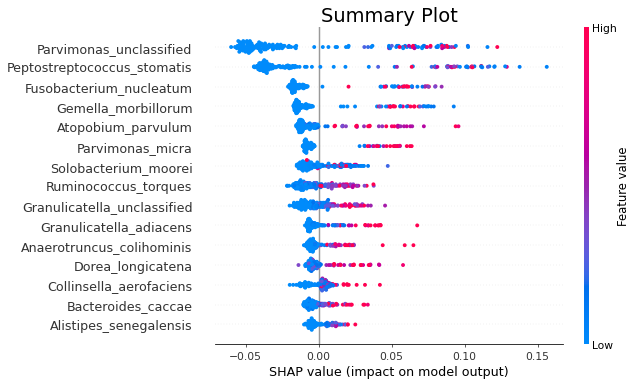

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(figsize=(8,6),dpi=70)
summary_plot(shap_values=shap_values,X=X_filtered,max_display=15) # max_display: number of features to display
plt.title('Summary Plot',fontsize=20)
plt.show()

# to save the image
plt.savefig('output/summary_plot.png')

# 7. Perform PCA on SHAP values

In [18]:
from shapmat.PCA import customPCA

In [19]:
n_components=2 # number of PCs
PCA = customPCA(X=shap_values_df,crc_proba=y_pred_proba,n_components=n_components)
shap_PC = PCA.PCA_scores()

shap_PC.head(3)

,PC1,PC2
subject_id,,
10037,-0.019296,-0.026073
10048,-0.056740,0.007039
10080,-0.021512,-0.031620


In [20]:
# calculate explained variance
cumulative_explained_var = PCA.cumulative_explained_variance()
cumulative_explained_var

,PC,Explained Variance,Cumulative Variance
0,PC1,0.549336,0.549
1,PC2,0.092255,0.641


### PCA Visualization

In [21]:
from shapmat.PCA_plot import PCAplot

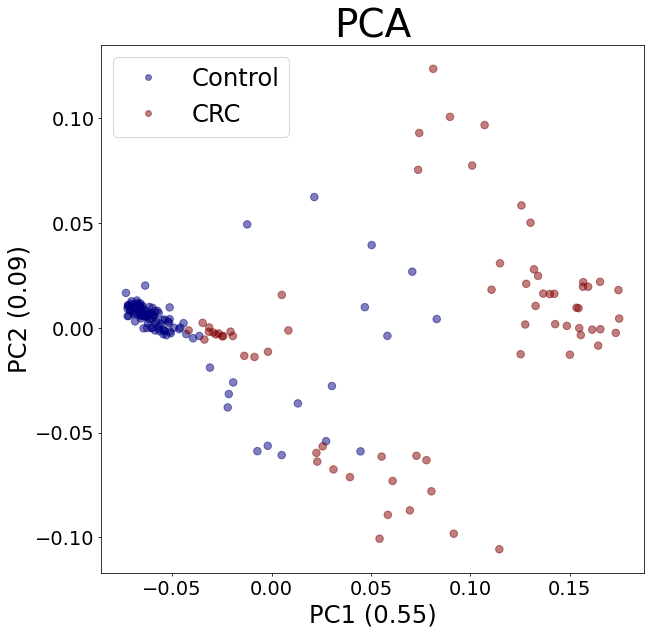

In [22]:
pca_plotter = PCAplot(PC_df=shap_PC,CEV_df=cumulative_explained_var,y=y,y_pred_crc_proba=y_pred_proba,correct_pred_only=True)

pca_plotter.plot_pca(figsize=(10,10),dpi=70,disease_label='CRC',savefig=True,output_path='output/pca_plot.png',title='PCA')

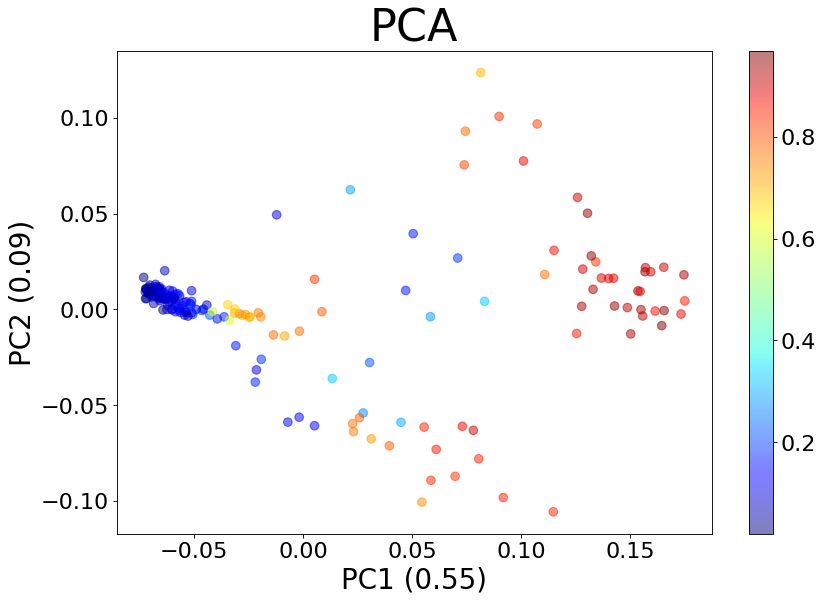

In [23]:
pca_plotter.plot_pca_with_proba(figsize=(8,8),dpi=70,savefig=True,output_path='output/pca_proba.png',title='PCA')

# 8. CRC Clustering using K-means

Next, we cluster the CRC subjects using K-means

In [24]:
from shapmat.clustering import shap_clustering

In [25]:
n_clust = 4
y_correct = y.loc[shap_PC.index]  # label of the correctly predicted subjects

CRC_kmeans = shap_clustering(PC_scores=shap_PC,y=y_correct)
CRC_kmeans_df = CRC_kmeans.kmeans(n_clusters=n_clust)

CRC_kmeans_df.head(3)

,PC1,PC2,cluster
subject_id,,,
1,-0.027951,-0.003158,2
10059,0.025720,-0.056601,3
10099,0.072919,-0.061098,3


### Visualize clusters using a scatter plot

In [26]:
from shapmat.clustering_plot import plot_cluster

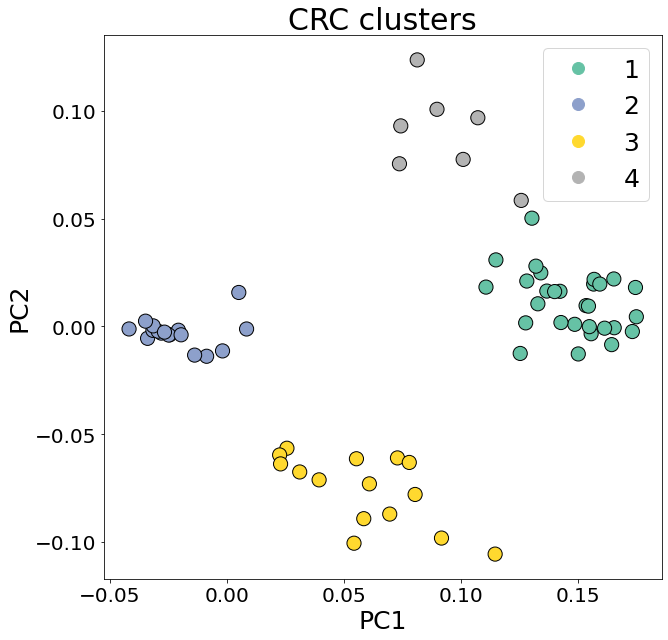

In [27]:
plot_cluster(CRC_cluster_df=CRC_kmeans_df,n_cluster=n_clust,figsize=(10,10),title='CRC clusters',savefig=True,output_path='output/kmeans.png')

#### Elbow method to choose the optimal number of cluster

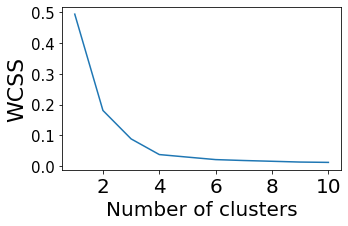

In [28]:
from shapmat.clustering_plot import plot_elbow_method
plot_elbow_method(CRC_cluster_df=CRC_kmeans_df)

# 9. Save Important Dataframes 

In [29]:
# shap values of all correctly predicted subjects 
shap_values_df.to_csv('output/shap.csv')

# predicted cluster labels of CRC subjects
CRC_kmeans_df.to_csv('output/CRC_cluster.csv')